# Imports

In [2]:
import torch
import torch.nn as nn  # All neural network modules, nn.linear, nn.conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that have no parameters
import torch.utils.data as DataLoader # Gives easier datasetmanagement and creates mini batches
import torchvision.datasets as datasets # Has Standard datasets we can import 
import torchvision.transforms as transforms # transformations we can perform on our dataset
import time
import random
import torchvision
import argparse



# Connect to Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


# VGG-16 MODEL

##### VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
##### Then flatten and 4096 x 4096 x 1000 linear layers

In [4]:
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13' : [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

decode_VGG_types = {
    'VGG11' : [512, 256, 128, 64],
    'VGG13' : [512, 256, 128, 64],
    'VGG16' : ['U', 512, 512, 512, 'U', 512, 512, 512, 'U', 256, 256, 256, 'U', 128, 128, 'U', 64, 64], #'VGG16' : [512, 256, 128, 64],
    'VGG19' : [512, 256, 128, 64]
}

In [5]:
import torchvision.models as models

# ** with the help of "https://github.com/say4n/pytorch-segnet/blob/master/src/model.py"
class VGG_net(nn.Module):
    
    def __init__(self, in_channels=3, out_channels = 49):
        super(VGG_net, self).__init__()
        
        # assign the in and out channels of the vgg model
        self.input_channels = in_channels
        self.output_channels = out_channels
        
        # ** use the pretrained vgg16 model from pytorch
        self.vgg16 = models.vgg16(pretrained=True)
        
        
        #################### ENCODING ####################
        # first ENCODING layer
        self.conv1_1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                 out_channels=64,
                                 kernel_size=(3,3), 
                                 stride=(1,1),
                                 padding=(1,1)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
        
        
        self.conv1_2 = nn.Sequential(nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU())
                
        self.max1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # second ENCODING layer
        self.conv2_1 = nn.Sequential(nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
        
        self.conv2_2 = nn.Sequential(nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU())
        
        self.max2 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # third ENCODING layer
        self.conv3_1 = nn.Sequential(nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self.conv3_2 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
        
        self.conv3_3 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(256),
                                     nn.ReLU())
                
        self.max3 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # forth ENCODING layer
        self.conv4_1 = nn.Sequential(nn.Conv2d(in_channels=256,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv4_2 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv4_3 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
                
        self.max4 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
         # fifth ENCODING layer
        self.conv5_1 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv5_2 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
        
        self.conv5_3 = nn.Sequential(nn.Conv2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                     nn.BatchNorm2d(512),
                                     nn.ReLU())
                
        self.max5 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), return_indices=True)
        
        # ** initialize the weights
        self.init_vgg_weigts()
        
        #################### DECODING ####################
        # first DECODING layer
        self.deconv1_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv1_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv1_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
                
        
        # second DECODING layer
        self.deconv2_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv2_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=512,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        
        self.deconv2_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=512,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
                
        
        # third DECODING layer
        self.deconv3_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.deconv3_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        
        self.deconv3_3 = nn.Sequential(nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
                
        
        # forth DECODING layer
        self.deconv4_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,
                               out_channels=128,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        
        self.deconv4_2 = nn.Sequential(nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
                
        
         # fifth DECODING layer
        self.deconv5_1 = nn.Sequential(nn.ConvTranspose2d(in_channels=64,
                               out_channels=64,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1)),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        
        self.deconv5_2 = nn.ConvTranspose2d(in_channels=64,
                               out_channels= out_channels,
                               kernel_size=(3,3), 
                               stride=(1,1),
                               padding=(1,1))
                
        
        
    def forward(self, x):

        # Call on Encoding Layers
        dim_0 = x.size() 
        x = self.conv1_1(x)
        x = self.conv1_2(x)
        x, ind_0 = self.max1(x)
        f1 = x
        
        dim_1 = x.size()
        x = self.conv2_1(x)
        x = self.conv2_2(x) 
        x, ind_1 = self.max2(x)
        f2 = x
        
        dim_2 = x.size()
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x, ind_2 = self.max3(x)
        f3 = x
        
        dim_3 = x.size()
        x = self.conv4_1(x) 
        x = self.conv4_2(x) 
        x = self.conv4_3(x)
        x, ind_3 = self.max4(x)
        f4 = x
        
        dim_4 = x.size()
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x, ind_4 = self.max5(x)
        f5 = x
        
       
        # Call on Decoding Layers
        dim_dec = x.size()
       
        x = F.max_unpool2d(x, ind_4, kernel_size=(2,2), stride=(2,2), output_size=dim_4)
        x = self.deconv1_1(x) 
        x = self.deconv1_2(x)
        x = self.deconv1_3(x)
        dim_d4 = x.size()

    
        x = F.max_unpool2d(x, ind_3, kernel_size=(2,2), stride=(2,2), output_size=dim_3)
        x = self.deconv2_1(x)
        x = self.deconv2_2(x)
        x = self.deconv2_3(x)
        dim_d3 = x.size()
        
     
        x = F.max_unpool2d(x, ind_2, kernel_size=(2,2), stride=(2,2), output_size=dim_2)
        x = self.deconv3_1(x) 
        x = self.deconv3_2(x)
        x = self.deconv3_3(x) 
        dim_d2 = x.size()
        
        
        x = F.max_unpool2d(x, ind_1, kernel_size=(2,2), stride=(2,2), output_size=dim_1)
        x = self.deconv4_1(x) 
        x = self.deconv4_2(x) 
        dim_d1 = x.size()
        
        
        x = F.max_unpool2d(x, ind_0, kernel_size=(2,2), stride=(2,2), output_size=dim_0)
        x = self.deconv5_1(x)
        x = self.deconv5_2(x) 
        dim_d0 = x.size()
            
        
        # last layer
        soft_max = F.softmax(x, dim=1) 
       
        return x, soft_max    
    
    
    
    # ** Initialize the weights
    def init_vgg_weigts(self):
        assert self.conv1_1[0].weight.size() == self.vgg16.features[0].weight.size()
        self.conv1_1[0].weight.data = self.vgg16.features[0].weight.data
        assert self.conv1_1[0].bias.size() == self.vgg16.features[0].bias.size()
        self.conv1_1[0].bias.data = self.vgg16.features[0].bias.data

        assert self.conv1_2[0].weight.size() == self.vgg16.features[2].weight.size()
        self.conv1_2[0].weight.data = self.vgg16.features[2].weight.data
        assert self.conv1_2[0].bias.size() == self.vgg16.features[2].bias.size()
        self.conv1_2[0].bias.data = self.vgg16.features[2].bias.data

        assert self.conv2_1[0].weight.size() == self.vgg16.features[5].weight.size()
        self.conv2_1[0].weight.data = self.vgg16.features[5].weight.data
        assert self.conv2_1[0].bias.size() == self.vgg16.features[5].bias.size()
        self.conv2_1[0].bias.data = self.vgg16.features[5].bias.data

        assert self.conv2_2[0].weight.size() == self.vgg16.features[7].weight.size()
        self.conv2_2[0].weight.data = self.vgg16.features[7].weight.data
        assert self.conv2_2[0].bias.size() == self.vgg16.features[7].bias.size()
        self.conv2_2[0].bias.data = self.vgg16.features[7].bias.data

        assert self.conv3_1[0].weight.size() == self.vgg16.features[10].weight.size()
        self.conv3_1[0].weight.data = self.vgg16.features[10].weight.data
        assert self.conv3_1[0].bias.size() == self.vgg16.features[10].bias.size()
        self.conv3_1[0].bias.data = self.vgg16.features[10].bias.data

        assert self.conv3_2[0].weight.size() == self.vgg16.features[12].weight.size()
        self.conv3_2[0].weight.data = self.vgg16.features[12].weight.data
        assert self.conv3_2[0].bias.size() == self.vgg16.features[12].bias.size()
        self.conv3_2[0].bias.data = self.vgg16.features[12].bias.data

        assert self.conv3_3[0].weight.size() == self.vgg16.features[14].weight.size()
        self.conv3_3[0].weight.data = self.vgg16.features[14].weight.data
        assert self.conv3_3[0].bias.size() == self.vgg16.features[14].bias.size()
        self.conv3_3[0].bias.data = self.vgg16.features[14].bias.data

        assert self.conv4_1[0].weight.size() == self.vgg16.features[17].weight.size()
        self.conv4_1[0].weight.data = self.vgg16.features[17].weight.data
        assert self.conv4_1[0].bias.size() == self.vgg16.features[17].bias.size()
        self.conv4_1[0].bias.data = self.vgg16.features[17].bias.data

        assert self.conv4_2[0].weight.size() == self.vgg16.features[19].weight.size()
        self.conv4_2[0].weight.data = self.vgg16.features[19].weight.data
        assert self.conv4_2[0].bias.size() == self.vgg16.features[19].bias.size()
        self.conv4_2[0].bias.data = self.vgg16.features[19].bias.data

        assert self.conv4_3[0].weight.size() == self.vgg16.features[21].weight.size()
        self.conv4_3[0].weight.data = self.vgg16.features[21].weight.data
        assert self.conv4_3[0].bias.size() == self.vgg16.features[21].bias.size()
        self.conv4_3[0].bias.data = self.vgg16.features[21].bias.data

        assert self.conv5_1[0].weight.size() == self.vgg16.features[24].weight.size()
        self.conv5_1[0].weight.data = self.vgg16.features[24].weight.data
        assert self.conv5_1[0].bias.size() == self.vgg16.features[24].bias.size()
        self.conv5_1[0].bias.data = self.vgg16.features[24].bias.data

        assert self.conv5_2[0].weight.size() == self.vgg16.features[26].weight.size()
        self.conv5_2[0].weight.data = self.vgg16.features[26].weight.data
        assert self.conv5_2[0].bias.size() == self.vgg16.features[26].bias.size()
        self.conv5_2[0].bias.data = self.vgg16.features[26].bias.data

        assert self.conv5_3[0].weight.size() == self.vgg16.features[28].weight.size()
        self.conv5_3[0].weight.data = self.vgg16.features[28].weight.data
        assert self.conv5_3[0].bias.size() == self.vgg16.features[28].bias.size()
        self.conv5_3[0].bias.data = self.vgg16.features[28].bias.data
    
    

In [6]:
from torchsummary import summary

# test summary of the model 
model = VGG_net(in_channels=3, out_channels=49)
x = torch.randn(1, 3, 226, 226)
summary(model, (3, 226, 226))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 226, 226]           1,792
       BatchNorm2d-2         [-1, 64, 226, 226]             128
              ReLU-3         [-1, 64, 226, 226]               0
            Conv2d-4         [-1, 64, 226, 226]          36,928
       BatchNorm2d-5         [-1, 64, 226, 226]             128
              ReLU-6         [-1, 64, 226, 226]               0
         MaxPool2d-7  [[-1, 64, 113, 113], [-1, 64, 113, 113]]               0
            Conv2d-8        [-1, 128, 113, 113]          73,856
       BatchNorm2d-9        [-1, 128, 113, 113]             256
             ReLU-10        [-1, 128, 113, 113]               0
           Conv2d-11        [-1, 128, 113, 113]         147,584
      BatchNorm2d-12        [-1, 128, 113, 113]             256
             ReLU-13        [-1, 128, 113, 113]               0
        MaxPool2d-14  [

# LoadBaches

In [7]:
import numpy as np
import cv2
import glob
import itertools
from matplotlib import pyplot as plt

# helper methods for image handling
class LoadBatches:
    
    
    # retrieves the input image array and resizes them to (224, 224) 
    def getImageArr(self, path, width, height, imgNorm="sub_mean", odering='channels_first'):
        try:
            img = cv2.imread(path, 1)

            if imgNorm == "sub_and_divide":
                img = np.float64(cv2.resize(img, (width, height))) / 127.5 - 1
            elif imgNorm == "sub_mean":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float64)
                img[:, :, 0] -= 103.939
                img[:, :, 1] -= 116.779
                img[:, :, 2] -= 123.68
            elif imgNorm == "divide":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float64)
                img = img / 255.0
            elif imgNorm == "no":
                img = cv2.resize(img, (width, height))
                img = img.astype(np.float32)


            if odering == 'channels_first':
                img = np.rollaxis(img, 2, 0)
            return img
        except Exception as e:
            print (path, e)
            img = np.zeros((height, width, 3))
            if odering == 'channels_first':
                img = np.rollaxis(img, 2, 0)
            return img

    # retrieves the label image masks array and resizes them to (224, 224) 
    def getSegmentationArr(self, path, nClasses, width, height):
        seg_labels = np.zeros((nClasses, height, width))
        try:
            img = cv2.imread(path, 1)
            img = cv2.resize(img[:, :, 0], (width, height), interpolation=cv2.INTER_NEAREST)
            for c in range(nClasses):
                seg_labels[c, :, :] = (img == c).astype(int)

        except Exception as e:
            print (e)

       
        return seg_labels



    # Generator for creating the training and validation sets by first calling on the resize methods above
    def imageSegmentationGenerator(self, images_path, segs_path, batch_size, n_classes, input_height, input_width, output_height,
                                   output_width):
        
        assert images_path[-1] == '/', images_path
        assert segs_path[-1] == '/', segs_path
        images = glob.glob(images_path + "*.jpg") +  glob.glob(images_path + '*.png') + glob.glob(images_path + "*.jpeg")
        images.sort()
        segmentations = glob.glob(segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg")
        segmentations.sort()

        assert len(images) == len(segmentations)
        i = 0
        for im, seg in zip(images, segmentations):
            i += 1
            assert (im.split('/')[-1].split(".")[0] == seg.split('/')[-1].split(".")[0])
          
        return images, segmentations


# ARGUMENTS

In [8]:
# parse arguments
parser = argparse.ArgumentParser()
parser.add_argument("--save_weights_path", type=str)
parser.add_argument("--train_images", type=str)
parser.add_argument("--train_labels", type=str)
parser.add_argument("--save_dir", type=str)
parser.add_argument("--n_classes", type=int)
parser.add_argument("--input_height", type=int, default=224)
parser.add_argument("--input_width", type=int, default=224)

parser.add_argument('--validate', action='store_false')
parser.add_argument("--val_images", type=str, default="")
parser.add_argument("--val_labels", type=str, default="")

parser.add_argument("--num_epochs", type=int, default=5)
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--val_batch_size", type=int, default=2)
parser.add_argument("--load_weights", type=str, default="")
parser.add_argument("--history_filename", type=str, default="history.txt")

parser.add_argument("--model_name", type=str, default="")
parser.add_argument("--optimizer_name", type=str, default="adadelta")
args = parser.parse_args(['--save_weights_path=weights/ex1w_AD_CN_5',
                          '--train_images=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/train/images/',
                          '--train_labels=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/train/mask/',
                          '--val_images=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/images/',
                          '--val_labels=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/mask/',
                          '--save_dir=/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/model/',
                          '--n_classes=49',
                          '--num_epochs=100',
                          '--model_name=vgg_net'
                          ])

In [9]:
# get arguments
train_images_path = args.train_images
train_segs_path = args.train_labels
train_batch_size = args.batch_size
n_classes = args.n_classes
input_height = args.input_height
input_width = args.input_width
validate = args.validate
save_weights_path = args.save_weights_path
epochs = args.num_epochs
load_weights = args.load_weights
saved_model_dir = args.save_dir

optimizer_name = args.optimizer_name
model_name = args.model_name
history_filename = args.history_filename


if validate:
    val_images_path = args.val_images
    val_segs_path = args.val_labels
    val_batch_size = args.val_batch_size

## **DataSet**

In [10]:
import torch
from PIL import Image

# list of all class labels
VOC_CLASSES = ('Background', # always first element is background
               'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 
               'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 
               'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus',
               'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 
               'Superior Temporal Gyrus, posterior division', 
               'Middle Temporal Gyrus, anterior division', 
               'Middle Temporal Gyrus, posterior division', 
               'Middle Temporal Gyrus, temporooccipital part',
               'Inferior Temporal Gyrus, anterior division',
               'Inferior Temporal Gyrus, posterior division', 
               'Inferior Temporal Gyrus, temporooccipital part', 
               'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 
               'Supramarginal Gyrus, posterior division', 'Angular Gyrus',
               'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 
               'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)',
               'Subcallosal Cortex', 'Paracingulate Gyrus', 'Cingulate Gyrus, anterior division',
               'Cingulate Gyrus, posterior division', 'Precuneous Cortex', 'Cuneal Cortex', 'Frontal Orbital Cortex',
               'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Lingual Gyrus',
               'Temporal Fusiform Cortex, anterior division', 'Temporal Fusiform Cortex, posterior division', 
               'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus', 'Frontal Operculum Cortex', 
               'Central Opercular Cortex', 'Parietal Operculum Cortex', 'Planum Polare', "Heschl's Gyrus (includes H1 and H2)", 
               'Planum Temporale', 'Supracalcarine Cortex', 'Occipital Pole')

# create dataset object
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, image_paths, mask_paths): 
        'Initialization'
        self.mask_paths = mask_paths
        self.image_paths = image_paths
        self.input_width = args.input_width
        self.input_height = args.input_height
        self.output_width = 224
        self.output_height = 224 
        self.n_classes = 49 
        self.lb = LoadBatches()
               

        #https://github.com/say4n/pytorch-segnet
        self.counts = self.__compute_class_probability()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_paths)

  def __getitem__(self, index):
        'Generates one sample of data'
        
        im_path = self.image_paths[index]
        msk_path = self.mask_paths[index]
       # retrieves the subject id for later reference for prediction task
        subject_id = int(im_path[73:76] + im_path[79:83])
        image = LoadBatches.getImageArr(lb, im_path, self.input_width, self.input_height)
        mask = LoadBatches.getSegmentationArr(lb, msk_path, n_classes, self.output_width, self.output_height)

      

        #https://github.com/say4n/pytorch-segnet
        # wraps the data
        data = {
                    'image': torch.FloatTensor(image),
                    'mask' : torch.LongTensor(mask),
                    'subj_id': subject_id 
                    
                    }

        return data
        

  #https://github.com/say4n/pytorch-segnet
  # computes class probability
  def __compute_class_probability(self):
    NUM_CLASSES = len(VOC_CLASSES)
    counts = dict((i, 0) for i in range(NUM_CLASSES))
    for i, name in enumerate(self.image_paths):
      mask_path = self.mask_paths[i]
      raw_image = Image.open(mask_path).resize((224, 224))
      imx_t = np.array(raw_image).reshape(224*224)
      imx_t[imx_t==255] = len(VOC_CLASSES)
      for i in range(NUM_CLASSES):
        counts[i] += np.sum(imx_t == i)
    return counts


  def get_class_probability(self):
    values = np.array(list(self.counts.values()))
    p_values = values/np.sum(values)
    return torch.Tensor(p_values)


##  Training 

In [ ]:
import os




# CONSTANTS
LR = 0.001
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256
NUM_CLASSES = 49
IM_NORM = 'sub_mean'
NUM_WORKERS = 6

# INSTANCES
lb = LoadBatches()

# create model forlder if not exists
model_dir = os.path.join('/content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/', "model")
if not os.path.exists(model_dir):
  os.makedirs(model_dir)


# load model
model =  VGG_net(in_channels=3, out_channels=49) 

# resume model 4 from 70 epochs to 100 epochs#
#resume_model = VGG_net(in_channels=3, out_channels=49) 
#SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_best_4.pth")
#resume_model.load_state_dict(torch.load(SAVED_MODEL_PATH))


# get the list of images and labels
images, labels = LoadBatches.imageSegmentationGenerator(lb, train_images_path, train_segs_path, train_batch_size, n_classes, input_height, input_width, OUTPUT_HEIGHT, OUTPUT_WIDTH)

# create DataSet object
train_set = Dataset(images, labels)

# create data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          shuffle=True,   
                          num_workers= NUM_WORKERS) 


#define the loss fn and optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss() 

#initialize empty list to track batch losses
batch_losses = []
# initialize the epoch tracker and loss tracker for the visualization chart
epoch_list = []
loss_list = []
acc_list = []

# checks the loss if it is better than previous value
is_better = True
prev_loss = float('inf')


In [ ]:
#for epoch in range(epochs):
for epoch in range(70, epochs):

        total_train = 0
        correct_train = 0
        epoch_list.append(epoch)
        loss_f = 0
        t_start = time.time()
        acc_f = 0
        print('EPOCH @@@@@@@@@@@@@@: ', epoch)
        print('t_start:  %%%%%%%%: ', t_start)
        print('LR == ', LR)

        #iterate over batches in dataloader
        for batch in train_loader:   
            # Get the inputs; data is a list of [inputs, labels]
            input_tensor = torch.autograd.Variable(batch['image'])
            target_tensor = torch.autograd.Variable(batch['mask'])
           
            # Initialise gradients
            optimizer.zero_grad()
            # Forward pass
            predicted_tensor, softmaxed_tensor = resume_model(input_tensor)
            # resize the dimentions of the target tensor
            target_tensor = torch.argmax(target_tensor, dim=1)
            # calculate loss function 
            loss = criterion(softmaxed_tensor, target_tensor)
            # Backward
            loss.backward()
            # Compute the loss and update the weights
            optimizer.step()

            # add the loss of the current batch 
            loss_f += loss.item()
           
            # calculate accuracy
            _, pred = torch.max(softmaxed_tensor, 1)
            total_train += target_tensor.nelement()
            correct_train += pred.eq(target_tensor.data).sum().item()
            train_accuracy = 100 * correct_train / total_train
            acc_f += train_accuracy

        # length of the dataloader
        dataloader_len = len(train_loader)
        # append epoch loss
        epoch_loss = loss_f/dataloader_len
        loss_list.append(epoch_loss)
        # append epoch accuracy
        epoch_acc = acc_f/dataloader_len
        acc_list.append(epoch_acc)
        # check the value of the loss with previous value
        delta = time.time() - t_start
        is_better = loss_f < prev_loss

        # save models from each epoch for later reference for plotting
        torch.save(model.state_dict(), os.path.join(model_dir, "model_epoch_{}.pth".format(epoch)))


        if is_better:
            prev_loss = loss_f
            torch.save(model.state_dict(), os.path.join(args.save_dir, "model_best_4_2.pth"))
            # model_best_1.pth. for 3 epochs
            # model_best_2.pth  for 30 epochs. 64
            # model_best_3.pth  for 25 epochs. 105
            # model_best_4.pth  for 70 epochs. 
        print('LOSS_F == ', loss_f)
        print("Epoch #{}  |  tLoss: {:.8f} | tACC: {:.8f}  |  t Time: {:2f}s".format(epoch+1, epoch_loss, epoch_acc, delta))


        print('loss_list ===', loss_list)
        print('acc_list ===', acc_list)
        print('epoch_list ===', epoch_list)



EPOCH @@@@@@@@@@@@@@:  70
t_start:  %%%%%%%%:  1598034905.78638
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #71  |  tLoss: 3.05091185 | tACC: 87.12701505  |  t Time: 603.173481s
loss_list === [3.0509118534909407]
acc_list === [87.12701505388532]
epoch_list === [70]
EPOCH @@@@@@@@@@@@@@:  71
t_start:  %%%%%%%%:  1598035513.6084824
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #72  |  tLoss: 3.05091185 | tACC: 88.14319272  |  t Time: 606.936466s
loss_list === [3.0509118534909407, 3.0509118534909407]
acc_list === [87.12701505388532, 88.14319271984421]
epoch_list === [70, 71]
EPOCH @@@@@@@@@@@@@@:  72
t_start:  %%%%%%%%:  1598036122.4670463
LR ==  0.001
LOSS_F ==  1516.3031911849976
Epoch #73  |  tLoss: 3.05091185 | tACC: 87.55493665  |  t Time: 605.499839s
loss_list === [3.0509118534909407, 3.0509118534909407, 3.0509118534909407]
acc_list === [87.12701505388532, 88.14319271984421, 87.55493665464684]
epoch_list === [70, 71, 72]
EPOCH @@@@@@@@@@@@@@:  73
t_start:  %%%%%%%%:  1598036

## Plotting Training Accuracy and Loss

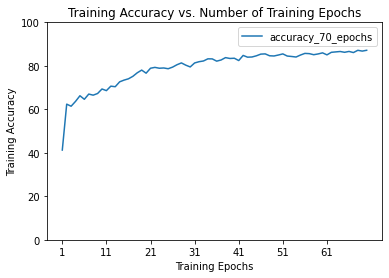

In [ ]:
# accuracy on 100 epochs
acc_list = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176, 87.12701505388532, 88.14319271984421, 87.55493665464684, 87.56272432879804, 87.73221677683222, 87.21551705921318, 87.62741607822404, 87.61005116066224, 87.2062764066737, 87.95252428352495, 87.99768213439181, 88.14209972625025, 87.4867594076394, 86.75077106898604, 87.68713555952279, 87.3415314438038, 88.36000236694896, 87.26398257733368, 87.30344575750794, 87.4706709240687, 87.49139616642753, 87.77269588642602, 87.65017251800728, 87.86298790367617, 87.74661477469947, 87.70549439351677, 87.5121548987188, 87.78640869029402, 87.35590975665798, 88.34516550622169]
# accuracy on 70 epochs
acc_list_70 = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176]
plt.close()
# plot acccuracy
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Accuracy")
plt.plot(range(1,70+1),acc_list_70,label="accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

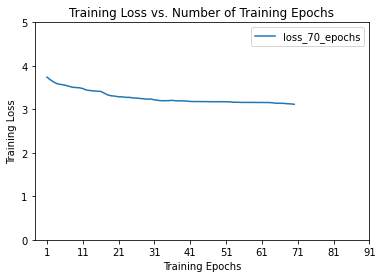

In [ ]:
# loss on 100 epochs
loss_list = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407, 3.0509118534909407]
# loss on 70 epochs
loss_list_70_epochs = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146]
plt.close()
# plot loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training Loss")
plt.plot(range(1,epochs+1),loss_list,label="loss_100_epochs")
plt.plot(range(1,70+1),loss_list_70_epochs,label="loss_70_epochs")
plt.ylim((0,5.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()

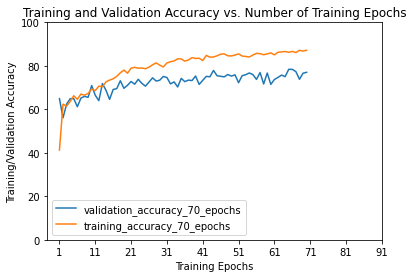

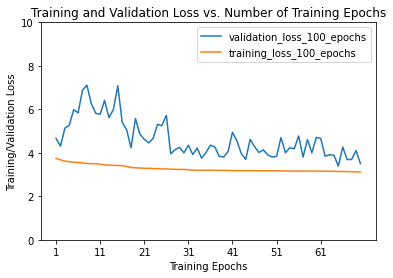

In [ ]:
plt.close()
acc_list_70 = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176]
loss_list_70_epochs = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146]
val_acc_list_70 = [64.93506202894093, 56.08991514412677, 62.3918805725029, 64.90623232590754, 64.90720557364176, 61.19603003578694, 65.17713561142922, 65.9738730048942, 65.5174168842467, 70.92563739305291, 66.4535314218075, 63.996945588276134, 71.86050437590579, 68.73275442826086, 64.57103284682672, 69.13406902155064, 69.53113672153381, 73.1328174114338, 69.67943797585806, 71.04905208935504, 72.80011023145951, 71.56101023901591, 73.81209655798257, 71.95314324274753, 70.66239974468401, 72.53765167294395, 74.48476304534019, 72.99972503445386, 73.40356062446975, 75.12100495266067, 74.64461286068763, 71.70236008015586, 72.62797976163534, 70.29069998680454, 74.23202982333815, 72.73714963334513, 73.43378441390624, 73.23187952993123, 75.32609312139375, 71.46133224550152, 73.32903992083676, 75.16628704976804, 74.97407779491546, 77.88163359519608, 75.45545864338484, 75.18962656927718, 74.9447714545183, 76.00981110363512, 75.27456728543989, 75.86867147641995, 72.24113092853963, 75.46628265419588, 75.94351839749388, 76.71795966805702, 75.96942987357872, 73.77091088890522, 76.91381767831909, 71.6624806716112, 76.69624826350238, 71.47629064911963, 73.72387643360358, 74.66917768784755, 75.74912283777743, 75.03936097736613, 78.40073691034866, 78.39002296594558, 77.34887563358365, 73.83201407886608, 76.60770165218408, 77.02753664515402]
val_loss_list_70 = [4.664805510514219, 4.307852337897663, 5.132734678160976, 5.26405238433623, 5.984090855423833, 5.8359418771636316, 6.889155846246531, 7.109611670735856, 6.256845292910723, 5.818175836348198, 5.770463653013739, 6.410162069428135, 5.619395850409924, 5.992142976169855, 7.08312906345851, 5.402436514975319, 5.058849581530397, 4.228623616863304, 5.577871230286612, 4.864918970725905, 4.622981585247416, 4.4544378015357005, 4.661464551804771, 5.304359711391825, 5.248533604850231, 5.725142304326447, 3.9534154534339905, 4.147698195047782, 4.250299888597408, 3.99855448158694, 4.349947894123239, 3.9211546149052365, 4.222139434075691, 3.7543379093559697, 4.015746405426885, 4.351557629209169, 4.266799285378255, 3.8331541612114703, 3.808592871880867, 4.058417726570452, 4.947525323276788, 4.550958225424861, 3.9636424695941765, 3.6949865263952337, 4.615570531764501, 4.28560874999409, 4.017715266053106, 4.135773411938842, 3.904325478513476, 3.807324269288023, 3.838362090184655, 4.704036053637384, 4.004674878758444, 4.231264789339522, 4.1864909638821235, 4.7758533022773095, 3.805234519528671, 4.60727518041369, 4.000565073020022, 4.705633400191723, 4.666319029431947, 3.845516945274783, 3.912545902628294, 3.88800546988635, 3.3886948059981976, 4.263234262735072, 3.690604869748505, 3.6956435811351724, 4.103452573359852, 3.5039917113075796]

# plot acccuracy
plt.title("Training and Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.plot(range(1,70+1),val_acc_list_70,label="validation_accuracy_70_epochs")
plt.plot(range(1,70+1),acc_list_70,label="training_accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()



# plot loss
plt.title("Training and Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training/Validation Loss")
plt.plot(range(1,70+1),val_loss_list_70,label="validation_loss_100_epochs")
plt.plot(range(1,70+1),loss_list_70_epochs,label="training_loss_100_epochs")
plt.ylim((0,10.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

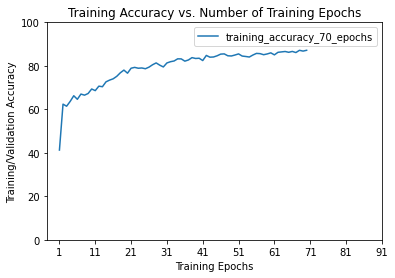

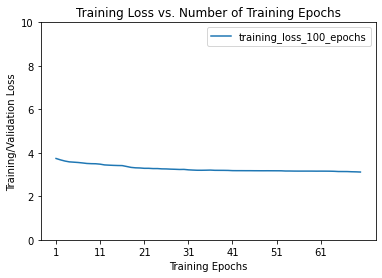

In [11]:
acc_list_70 = [41.27648835604686, 62.38594578919693, 61.431933042433315, 63.65238155684716, 66.24623267839004, 64.61978502215472, 67.01767772745792, 66.52130876804586, 67.27904174393196, 69.35545182964505, 68.60380358217192, 70.65988735685762, 70.40220146232635, 72.64754975903284, 73.44117901105321, 74.04281799037891, 75.18137131079304, 76.81506275705392, 78.04720525019225, 76.62631398312679, 78.90545930967409, 79.29773976279505, 78.90278332656145, 79.02218946950124, 78.67063826485278, 79.41192680727416, 80.51150051743718, 81.34856328853637, 80.3128394573011, 79.49648845985702, 81.32823370490472, 81.90747852405863, 82.2362370321683, 83.22367431820423, 83.19788707828508, 82.160319004913, 82.69752797814758, 83.78238379941787, 83.3938617869502, 83.49783631932192, 82.4377412144981, 84.79187778983749, 83.98948717134051, 84.0718590891266, 84.6199159654323, 85.3944318382787, 85.50164575014698, 84.63131305139692, 84.53686143660323, 84.9847501664276, 85.4969054061543, 84.50605898143546, 84.3051722798138, 84.05936109240145, 84.97891388821581, 85.7252748376863, 85.61498153400262, 85.1215537134892, 85.47774874492912, 85.97311076219549, 85.05472913501238, 86.22592975285355, 86.4160343092698, 86.59965730773986, 86.23304190688573, 86.62994484332475, 86.11116055656024, 87.15004818191962, 86.78340938174938, 87.15601770660176]
loss_list_70_epochs = [3.739976757249122, 3.6759780446288572, 3.6228611157453754, 3.584424921684342, 3.57016366780164, 3.5558267191382242, 3.534532097983408, 3.510327455743218, 3.5009809533355223, 3.4969047339149646, 3.4782048303116735, 3.4438611156264063, 3.4326089536640008, 3.4231463682723478, 3.416548250186851, 3.4125956798223425, 3.3719136422308877, 3.330183819266152, 3.310611918658558, 3.3037548722395713, 3.2876998322830353, 3.287447780190819, 3.275676827555451, 3.2757857685357754, 3.2623886663908928, 3.259084630060484, 3.2491585728628056, 3.242886199797663, 3.234524550812105, 3.23771057618216, 3.2177238090177416, 3.2068882257166043, 3.1984384549215767, 3.1978711885225843, 3.2011082508194613, 3.20589757829125, 3.1958012211490683, 3.194570457431632, 3.193804332667913, 3.190595260808166, 3.18102510834124, 3.1794381189634144, 3.179319934825782, 3.1780607436504402, 3.178268298296861, 3.1763842801452884, 3.1757423124562805, 3.174906609763562, 3.1756849979730677, 3.1747987323123925, 3.173803165405089, 3.1733177336648675, 3.163581253297372, 3.16346928243426, 3.159932219046702, 3.1590442796588185, 3.159184462107883, 3.159194261735114, 3.1590768441827723, 3.156971197013164, 3.15797443744882, 3.15701491827936, 3.155622679462855, 3.1509447035415312, 3.1402814249157665, 3.1393382841912314, 3.1382171028336767, 3.129702519123223, 3.1249943446345494, 3.11653772590146]

# plot acccuracy
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.plot(range(1,70+1),acc_list_70,label="training_accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, epochs+1, 10.0))
plt.legend()
plt.show()



# plot loss
plt.title("Training Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Training/Validation Loss")
plt.plot(range(1,70+1),loss_list_70_epochs,label="training_loss_100_epochs")
plt.ylim((0,10.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

# Validation

In [ ]:
# close all the plot windows 
plt.close('all')

In [12]:
def validate(val_dataloader, model, OUTPUT_DIR):
    model.eval()

    # track accuracy and loss
    total_test = 0
    correct_test = 0
    loss_final = 0
    acc_final = 0

    # directory for saving the prediction images
    pred_dir = os.path.join(saved_model_dir, "pred_images") #_70_epoch
    if not os.path.exists(pred_dir):
      os.makedirs(pred_dir)

    # initialize random colors for plotting
    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(n_classes)]

    for batch_idx, batch in enumerate(val_dataloader):
        # get input and target tensors
        input_tensor = torch.autograd.Variable(batch['image'])
        target_tensor = torch.autograd.Variable(batch['mask'])
        subj_id = torch.autograd.Variable(batch['subj_id'])
        subject_id = subj_id.numpy()[0]
        
        # fit into model
        predicted_tensor, softmaxed_tensor = model(input_tensor)
        # argmax on the target tensor to resize
        target_tensor_resized = torch.argmax(target_tensor, dim=1)
        # calculate loss
        loss = criterion(predicted_tensor, target_tensor_resized)
        loss_final += loss.item()
        # calculate accuracy
        _, pred = torch.max(softmaxed_tensor, 1)
        total_test += target_tensor_resized.nelement()
        acc_item = pred.eq(target_tensor_resized.data).sum().item()
        correct_test += acc_item
        test_accuracy = 100 * correct_test / total_test
        acc_final += test_accuracy
        
        
        for idx, predicted_mask in enumerate(softmaxed_tensor):
            # plot images alongside each other as well as save the predicted images seperatly in plotimages
            target_mask = target_tensor[idx]
            input_image = input_tensor[idx]
            fig = plt.figure()
            # convert input data from torch tensor to numpy array
            # image resized from (3,224,224) to (224,224,3) for plotting
            image_input = input_image.permute(1, 2, 0).numpy()[:,:,:]

            # mask resized from (49,224,224) to (224,224) for plotting each pixel to be a class number from 0-49
            # now target_numpy is a torch tensor with size (224,224)
            target_numpy = torch.argmax(target_mask, dim=0)
            target_mx = target_numpy.numpy()   
            # ADD A 3RD DIMENTION (BY COPYING THE FIRST IMAGE 2 MORE TIMES) TO BE ABLE TO PLOT THE MASK 
            target_mx = np.repeat(target_mx[:, :, np.newaxis], 3, axis=2).astype(np.uint8)

            # convert predicted data from torch tensor to numpy array
            predicted_mx = torch.argmax(predicted_mask.squeeze(), dim=0).detach().cpu().numpy()
            predicted_mx = np.repeat(predicted_mx[:, :, np.newaxis], 3, axis=2).astype(np.uint8)
           
            # plot images
            plotImages(image_input, target_mx, predicted_mx, 49, batch_idx, idx, OUTPUT_DIR, pred_dir, colors, subject_id, validation=True)
        
        
        plt.close('all')


    # after all batches print the total loss and accuracy and plot them
    val_epoch_loss = loss_final/len(val_dataloader)  
    val_epoch_acc = acc_final/len(val_dataloader) 
    print('loss total ==', val_epoch_loss)
    print('accuracy total ==', val_epoch_acc)
    return val_epoch_loss, val_epoch_acc



In [14]:
import os
import matplotlib.image as pltimage
# constants
NUM_INPUT_CHANNELS = 3
NUM_OUTPUT_CHANNELS = 49
NUM_BACHES = 2
NUM_EPOCHS = 10

LR = 0.001

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

OUTPUT_WIDTH = 256
OUTPUT_HEIGHT = 256

NUM_WORKERS = 4



val_img_dir = val_images_path
val_mask_dir = val_segs_path

SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_epoch_69.pth")

# create output directory
OUTPUT_DIR = os.path.join(saved_model_dir, "predictions_70_3")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#instances
lb = LoadBatches()
    
print('image directory: ', val_img_dir)
print('mask directory: ', val_mask_dir)

# get the list of images and labels
val_images_paths, val_labels_paths = LoadBatches.imageSegmentationGenerator(lb, val_img_dir, val_mask_dir, NUM_BACHES, NUM_OUTPUT_CHANNELS, input_height, input_width, OUTPUT_HEIGHT, OUTPUT_WIDTH)

# initialize dataset
val_dataset = Dataset(val_images_paths, val_labels_paths)

# create data loader
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                          batch_size=NUM_BACHES,
                          shuffle=True,   
                          num_workers= NUM_WORKERS)

# load model
model =  VGG_net(in_channels=NUM_INPUT_CHANNELS, out_channels=NUM_OUTPUT_CHANNELS) 
# criterian
criterion = torch.nn.CrossEntropyLoss()
# load trained model
model.load_state_dict(torch.load(SAVED_MODEL_PATH))




image directory:  /content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/images/
mask directory:  /content/drive/My Drive/ADNI_2_400_12_subjects/ADNI/T1/tests/mask/


<All keys matched successfully>

In [ ]:
# CALL VALIDATION FUNCTION ON 70th EPOCH (the segmentaiton results)
val_loss, val_acc = validate(val_dataloader, model, OUTPUT_DIR)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


PLOT IMAGE
loss total == 3.7659430024779845
accuracy total == 75.84500456295875


In [ ]:
# validation Accuracy and loss for 70 epochs
# FOR THE SAME IMAGES AND LABELS IN VALID FORLDER, RUN 69 DIFFERENT MODELS TO TRACKING THE ACCURACY AND LOSS
loss_arr = []
acc_arr = []
for i in range(0,70):
    # load model
  SAVED_MODEL_PATH = os.path.join(saved_model_dir, "model_epoch_{}.pth".format(i))
  model_i =  VGG_net(in_channels=NUM_INPUT_CHANNELS, out_channels=NUM_OUTPUT_CHANNELS) 
  criterion = torch.nn.CrossEntropyLoss() 
  model_i.load_state_dict(torch.load(SAVED_MODEL_PATH))
  # VALIDATE MODEL
  loss, acc = validate(val_dataloader, model_i, OUTPUT_DIR)
  print('epoch_{}_loss == {}'.format(i, loss))
  print('epoch_{}_accuracy == {}'.format(i, acc))

  loss_arr.append(loss)
  acc_arr.append(acc)



print('loss_arr == ', loss_arr)
print('acc_arr == ', acc_arr)




loss total == 4.664805510514219
accuracy total == 64.93506202894093
epoch_0_loss == 4.664805510514219
epoch_0_accuracy == 64.93506202894093
loss total == 4.307852337897663
accuracy total == 56.08991514412677
epoch_1_loss == 4.307852337897663
epoch_1_accuracy == 56.08991514412677
loss total == 5.132734678160976
accuracy total == 62.3918805725029
epoch_2_loss == 5.132734678160976
epoch_2_accuracy == 62.3918805725029
loss total == 5.26405238433623
accuracy total == 64.90623232590754
epoch_3_loss == 5.26405238433623
epoch_3_accuracy == 64.90623232590754
loss total == 5.984090855423833
accuracy total == 64.90720557364176
epoch_4_loss == 5.984090855423833
epoch_4_accuracy == 64.90720557364176
loss total == 5.8359418771636316
accuracy total == 61.19603003578694
epoch_5_loss == 5.8359418771636316
epoch_5_accuracy == 61.19603003578694
loss total == 6.889155846246531
accuracy total == 65.17713561142922
epoch_6_loss == 6.889155846246531
epoch_6_accuracy == 65.17713561142922
loss total == 7.109611

## Plotting Accuracy and Loss for Validation Over Epochs

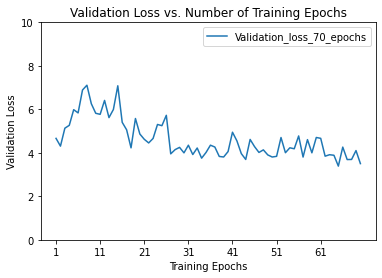

In [ ]:
# accuracy on 70 epochs
val_loss_list_70 = [4.664805510514219, 4.307852337897663, 5.132734678160976, 5.26405238433623, 5.984090855423833, 5.8359418771636316, 6.889155846246531, 7.109611670735856, 6.256845292910723, 5.818175836348198, 5.770463653013739, 6.410162069428135, 5.619395850409924, 5.992142976169855, 7.08312906345851, 5.402436514975319, 5.058849581530397, 4.228623616863304, 5.577871230286612, 4.864918970725905, 4.622981585247416, 4.4544378015357005, 4.661464551804771, 5.304359711391825, 5.248533604850231, 5.725142304326447, 3.9534154534339905, 4.147698195047782, 4.250299888597408, 3.99855448158694, 4.349947894123239, 3.9211546149052365, 4.222139434075691, 3.7543379093559697, 4.015746405426885, 4.351557629209169, 4.266799285378255, 3.8331541612114703, 3.808592871880867, 4.058417726570452, 4.947525323276788, 4.550958225424861, 3.9636424695941765, 3.6949865263952337, 4.615570531764501, 4.28560874999409, 4.017715266053106, 4.135773411938842, 3.904325478513476, 3.807324269288023, 3.838362090184655, 4.704036053637384, 4.004674878758444, 4.231264789339522, 4.1864909638821235, 4.7758533022773095, 3.805234519528671, 4.60727518041369, 4.000565073020022, 4.705633400191723, 4.666319029431947, 3.845516945274783, 3.912545902628294, 3.88800546988635, 3.3886948059981976, 4.263234262735072, 3.690604869748505, 3.6956435811351724, 4.103452573359852, 3.5039917113075796]
plt.close()
# plot acccuracy
plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Loss")
plt.plot(range(1,70+1),val_loss_list_70,label="Validation_loss_70_epochs")
plt.ylim((0,10.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

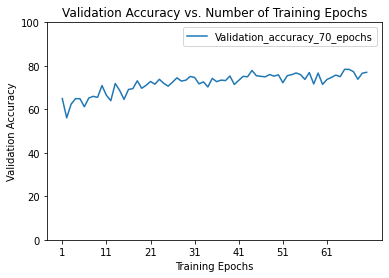

In [ ]:
# accuracy on 70 epochs
val_acc_list_70 = [64.93506202894093, 56.08991514412677, 62.3918805725029, 64.90623232590754, 64.90720557364176, 61.19603003578694, 65.17713561142922, 65.9738730048942, 65.5174168842467, 70.92563739305291, 66.4535314218075, 63.996945588276134, 71.86050437590579, 68.73275442826086, 64.57103284682672, 69.13406902155064, 69.53113672153381, 73.1328174114338, 69.67943797585806, 71.04905208935504, 72.80011023145951, 71.56101023901591, 73.81209655798257, 71.95314324274753, 70.66239974468401, 72.53765167294395, 74.48476304534019, 72.99972503445386, 73.40356062446975, 75.12100495266067, 74.64461286068763, 71.70236008015586, 72.62797976163534, 70.29069998680454, 74.23202982333815, 72.73714963334513, 73.43378441390624, 73.23187952993123, 75.32609312139375, 71.46133224550152, 73.32903992083676, 75.16628704976804, 74.97407779491546, 77.88163359519608, 75.45545864338484, 75.18962656927718, 74.9447714545183, 76.00981110363512, 75.27456728543989, 75.86867147641995, 72.24113092853963, 75.46628265419588, 75.94351839749388, 76.71795966805702, 75.96942987357872, 73.77091088890522, 76.91381767831909, 71.6624806716112, 76.69624826350238, 71.47629064911963, 73.72387643360358, 74.66917768784755, 75.74912283777743, 75.03936097736613, 78.40073691034866, 78.39002296594558, 77.34887563358365, 73.83201407886608, 76.60770165218408, 77.02753664515402]
plt.close()
# plot acccuracy
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,70+1),val_acc_list_70,label="Validation_accuracy_70_epochs")
plt.ylim((0,100.))
plt.xticks(np.arange(1, 70+1, 10.0))
plt.legend()
plt.show()

In [ ]:
val_loss_list_70 = [4.664805510514219, 4.307852337897663, 5.132734678160976, 5.26405238433623, 5.984090855423833, 5.8359418771636316, 6.889155846246531, 7.109611670735856, 6.256845292910723, 5.818175836348198, 5.770463653013739, 6.410162069428135, 5.619395850409924, 5.992142976169855, 7.08312906345851, 5.402436514975319, 5.058849581530397, 4.228623616863304, 5.577871230286612, 4.864918970725905, 4.622981585247416, 4.4544378015357005, 4.661464551804771, 5.304359711391825, 5.248533604850231, 5.725142304326447, 3.9534154534339905, 4.147698195047782, 4.250299888597408, 3.99855448158694, 4.349947894123239, 3.9211546149052365, 4.222139434075691, 3.7543379093559697, 4.015746405426885, 4.351557629209169, 4.266799285378255, 3.8331541612114703, 3.808592871880867, 4.058417726570452, 4.947525323276788, 4.550958225424861, 3.9636424695941765, 3.6949865263952337, 4.615570531764501, 4.28560874999409, 4.017715266053106, 4.135773411938842, 3.904325478513476, 3.807324269288023, 3.838362090184655, 4.704036053637384, 4.004674878758444, 4.231264789339522, 4.1864909638821235, 4.7758533022773095, 3.805234519528671, 4.60727518041369, 4.000565073020022, 4.705633400191723, 4.666319029431947, 3.845516945274783, 3.912545902628294, 3.88800546988635, 3.3886948059981976, 4.263234262735072, 3.690604869748505, 3.6956435811351724, 4.103452573359852, 3.5039917113075796]
average_loss = sum(val_loss_list_70)/len(val_loss_list_70)
average_loss


val_acc_list_70 = [64.93506202894093, 56.08991514412677, 62.3918805725029, 64.90623232590754, 64.90720557364176, 61.19603003578694, 65.17713561142922, 65.9738730048942, 65.5174168842467, 70.92563739305291, 66.4535314218075, 63.996945588276134, 71.86050437590579, 68.73275442826086, 64.57103284682672, 69.13406902155064, 69.53113672153381, 73.1328174114338, 69.67943797585806, 71.04905208935504, 72.80011023145951, 71.56101023901591, 73.81209655798257, 71.95314324274753, 70.66239974468401, 72.53765167294395, 74.48476304534019, 72.99972503445386, 73.40356062446975, 75.12100495266067, 74.64461286068763, 71.70236008015586, 72.62797976163534, 70.29069998680454, 74.23202982333815, 72.73714963334513, 73.43378441390624, 73.23187952993123, 75.32609312139375, 71.46133224550152, 73.32903992083676, 75.16628704976804, 74.97407779491546, 77.88163359519608, 75.45545864338484, 75.18962656927718, 74.9447714545183, 76.00981110363512, 75.27456728543989, 75.86867147641995, 72.24113092853963, 75.46628265419588, 75.94351839749388, 76.71795966805702, 75.96942987357872, 73.77091088890522, 76.91381767831909, 71.6624806716112, 76.69624826350238, 71.47629064911963, 73.72387643360358, 74.66917768784755, 75.74912283777743, 75.03936097736613, 78.40073691034866, 78.39002296594558, 77.34887563358365, 73.83201407886608, 76.60770165218408, 77.02753664515402]
average_accuracy = sum(val_acc_list_70)/len(val_acc_list_70)
average_accuracy

In [ ]:
def plotImages(image, seg, pred, n_classes, batch_idx, idx, OUTPUT_DIR, pred_dir, colors, file_name, validation=False):

  seg_img = np.zeros_like(seg)
  pred_img = np.zeros_like(pred)
  # color code the regions of the mask and predicted image
  for c in range(n_classes):

    seg_img[:, :, 0] += ((seg[:, :, 0] == c) * (colors[c][0])).astype('uint8')
    seg_img[:, :, 1] += ((seg[:, :, 0] == c) * (colors[c][1])).astype('uint8')
    seg_img[:, :, 2] += ((seg[:, :, 0] == c) * (colors[c][2])).astype('uint8')


    pred_img[:, :, 0] += ((pred[:, :, 0] == c) * (colors[c][0])).astype('uint8')
    pred_img[:, :, 1] += ((pred[:, :, 0] == c) * (colors[c][1])).astype('uint8')
    pred_img[:, :, 2] += ((pred[:, :, 0] == c) * (colors[c][2])).astype('uint8')
    
  
  # plot images
  plt.figure(figsize=(10, 10))
  fig = plt.figure()

  a = fig.add_subplot(1,3,1)    
  plt.imshow(image)
  a.set_title("Original image") 

  a = fig.add_subplot(1,3,2)
  plt.imshow(seg_img)
  a.set_title("mask image")


  a = fig.add_subplot(1,3,3)
  plt.imshow(pred_img)
  a.set_title("predicted image")

  # save plots
  if validation == True:
    # save predictions
    plt.imsave(os.path.join(pred_dir, "prediction_{}_{}.png".format(batch_idx, file_name)), pred_img) #, cmap="gray"
    # save plots 
    out_dir = os.path.join(OUTPUT_DIR, "prediction_{}_{}.png".format(batch_idx, file_name))
    fig.savefig(out_dir)

    plt.close(fig)
